# Mutual debts graph reduction

In [2]:
import networkx as nx
import numpy as np
import scipy as sp
from scipy.sparse import rand, csr_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# generate test data
np.random.seed(42)

def generate_adj_matrix(people_number, fill_factor = 0.5, hide_negative = True):
    # generate random sparse matrix
    adj_matrix = sp.sparse.rand(people_number,
                                people_number,
                                density = fill_factor,
                                format = 'csr',
                                random_state = np.random.randint(1))

    # make it dense (in order to remove zero weights from graph)
    adj_matrix = adj_matrix.todense()
    # remove main diagonal elements
    adj_matrix[np.arange(people_number), np.arange(people_number)] = 0
    # make matrix semi symetric
    adj_matrix = adj_matrix - adj_matrix.T
    
    # remove negative arcs if necessary
    if hide_negative:
        adj_matrix[adj_matrix < 0] = 0
    
    # round weights
    for i in range(people_number):
        for j in range(people_number):
            adj_matrix[i, j] = int(100 * adj_matrix[i, j])
    
    return csr_matrix(adj_matrix)


# compute node balance
def balance(G, i):
    balance = 0
    
    sparse_matrix = nx.adjacency_matrix(G)
    
    balance += sparse_matrix[:, i].sum()
    balance -= sparse_matrix[i, :].sum()
            
    return balance
    

def draw_graph(G, show_edges_labels = True):
    plt.figure(figsize = (15,10))
    plt.axis('off')

    pos = nx.circular_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size = 4000)
    nx.draw_networkx_edges(G, pos)
    
    if show_edges_labels:
        labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels = labels)
    
    labels = {}

    for node in G.nodes():
        labels[node] = ':'.join(['N' + str(node), str(balance(G, node))])
        
    nx.draw_networkx_labels(G, pos, labels = labels)
    

# check solution
def check_solution(G_orig, G_resolved):
    for node in G_orig.nodes():
        if np.abs(balance(G_orig, node) - balance(G_resolved, node)) >= 10e-7:
            return False
        
    return True

First aproach is delete all the previous connections, all the creditors should be satisfied with debtors using the least possible amount of arcs between them.

This equal to the following optimization problem:

### Mixed Integer Problem

* Let $I$ be the set of people who still must pay money.
* Let $J$ be the set of people who still must receive money.
* Let $d_i$ be a constant representing the amount of money person $i$ must pay (where $i \in I$).
* Let $c_j$ be a constant representing the amount of money person $j$ must receive (where $j \in J$).
* Let $x_{ij} \in [0, 1]$ be a decision variable representing the persentage of total debt $d_i$ person $i$ pays to person $j$.
Example: player $1$ owes $10$, then $x_{12}=0.75$ would mean person $1$ pays person $2$ $7.50$.
* Let $y_{ij} \in \{0, 1\}$ represent whether person $i$ made a transaction with person $j$ (where $i \in I$ and $j \in J$). The variable takes on value 1 if a transaction was made and 0 otherwise.
* Objective is to minimize the total number of transactions:

\begin{equation*}
\begin{aligned}
& \underset{i \in I, j \in J}{\text{minimize}}
& & \sum_{i \in I, j \in J} y_{ij} \\\\
& s.t.
& &  \sum_{j \in J} x_{ij} = 1 \\ \forall i \in I \\\\
& & & \sum_{i \in I} d_i * x_{ij} = c_j \\ \forall j \in J \\\\
& & & x_{ij} \leq y_{ij}
\end{aligned}
\end{equation*}
* First constraint is that each person who owes money pays exactly what they owe:
$$\sum_{j \in J} x_{ij} = 1 (\forall i \in I)$$
* Second constraint is that each person who must receive money gets the exact amount they're supposed to receive:
$$\sum_{i \in I} d_i * x_{ij} = c_j (\forall j \in J)$$
* Last constraint relates the $x$ and $y$ decision variables. That is, it defines what it means for a transaction to occur between $i$ and $j$. A transaction occurs if and only if $i$ pays some nonzero amount to $j$ (i.e., $x_{ij} > 0$):
$$ x_{ij} > 0 \Rightarrow y_{ij} = 1 $$

In another words:
$$x_{ij} \leq y_{ij}$$

Solution is valid


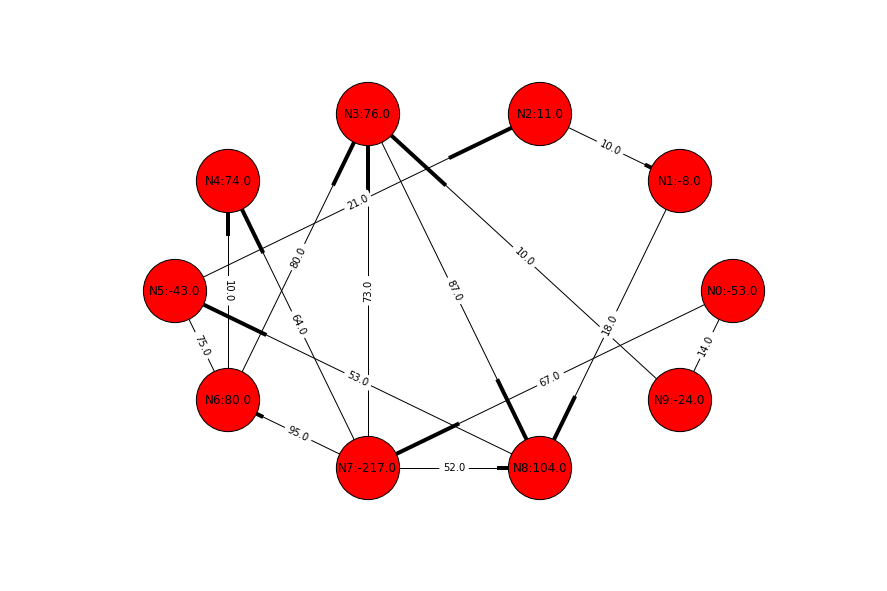

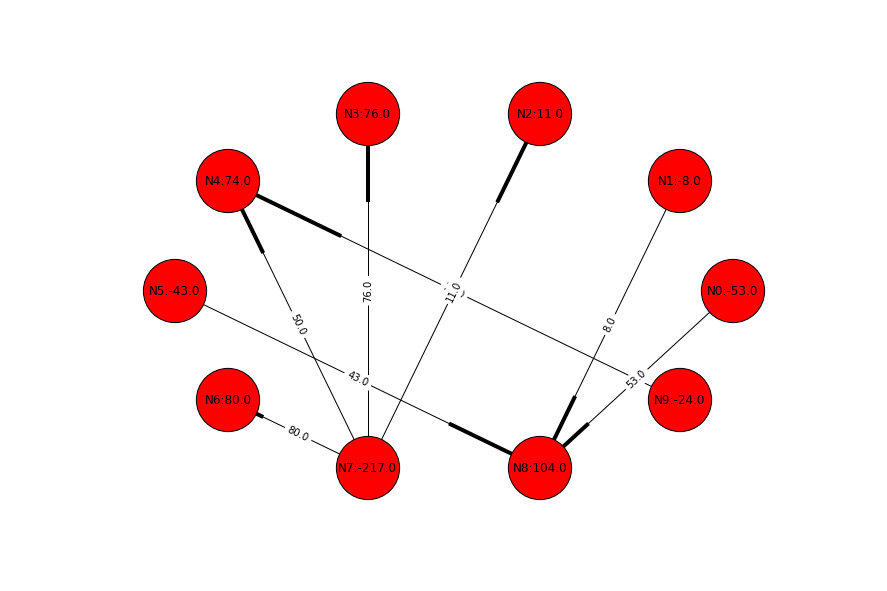

In [3]:
import cvxpy as cvx
from scipy.sparse import lil_matrix

class MIPSolver():
    def extract_relations(self, data):
        debtors = []
        creditors = []
        d = []
        c = []

        for i in range(data.shape[0]):
            row_sum = data[i, :].sum()
            col_sum = data[:, i].sum()

            if row_sum > col_sum:
                debtors.append(i)
                d.append(row_sum - col_sum)
            elif row_sum < col_sum:
                creditors.append(i)
                c.append(col_sum - row_sum)

        return np.array(debtors), np.array(creditors), np.array(d), np.array(c)

    def postprocess(self, solution, debtors, creditors, data, d):
        people_number = data.shape[0]
        result = lil_matrix((people_number, people_number))

        for row_index, row in enumerate(np.array(solution)):
            for coll_index, value in enumerate(row):
                payment = d[row_index]
                result[debtors[row_index], creditors[coll_index]] = value * payment
        
        return result

    def solve(self, data):
        debtors, creditors, d, c = self.extract_relations(data)

        X = cvx.Variable(d.size, c.size)
        Y = cvx.Bool(d.size, c.size)

        objective = cvx.Minimize(cvx.sum_entries(Y))
        constraints = [0 <= X,
                       X <= Y,
                       Y <= 1]
        
        for i in range(d.size):
            constraints.append(cvx.sum_entries(X[i, :]) == 1)
        for j in range(c.size):
            constraints.append((d.T * X)[j] == c[j])

        problem = cvx.Problem(objective, constraints)
        problem.solve(solver = 'GUROBI')
        
        return self.postprocess(X.value, debtors, creditors, data, d)
    

mip_solver = MIPSolver()

people_number = 10
data = generate_adj_matrix(people_number, 0.2, True)

G = nx.DiGraph(data)
G_solution = nx.DiGraph(mip_solver.solve(data))

draw_graph(G)
draw_graph(G_solution)

if check_solution(G, G_solution):
    print('Solution is valid')

The maxium problem size that can be solved using this approach is 43 people graph. This is the restriction of GUROBI liscense for online courses that we used. (No more that 2000 variables). Also it is important to mention that this solution always has at most N - 1 edges, where N is the number of vertices.
Then we have tried to solve this problem using another formulation that allows us to solve problem for up to 43 persons in a group.

## Search for min cost flow

$$ \min_{x} \sum_{i, j} c_{i,j}\\
\text{s.t.:} \quad 0 \leq c_{ij}\\
\sum_{i=1}^n c_{ij} - \sum_{j=1}^n c_{ij} = \sum_{i=1}^n u_{ij} - \sum_{j=1}^n u_{ij}
$$

Matrix $c$ represents how much money is transfered during the transaction between $i$ and $j$.

Solution is valid


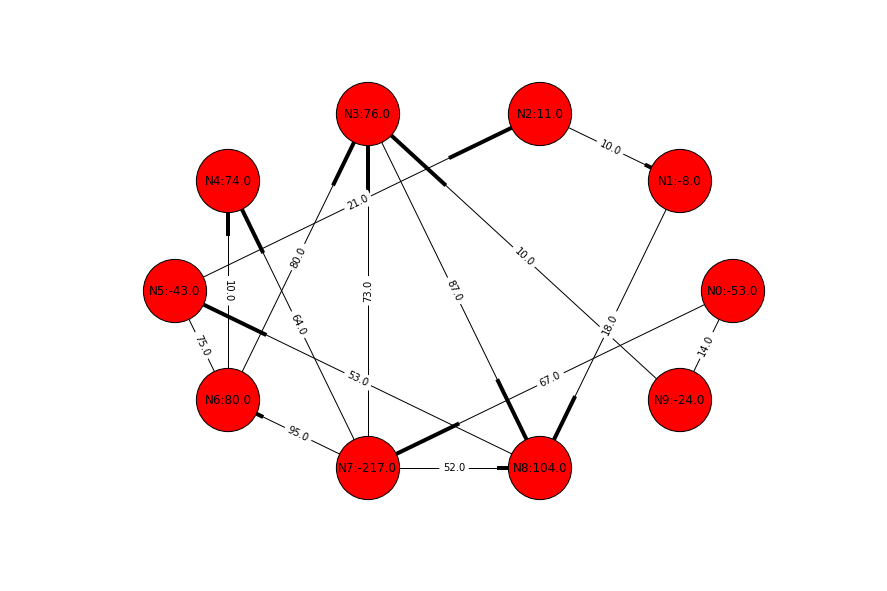

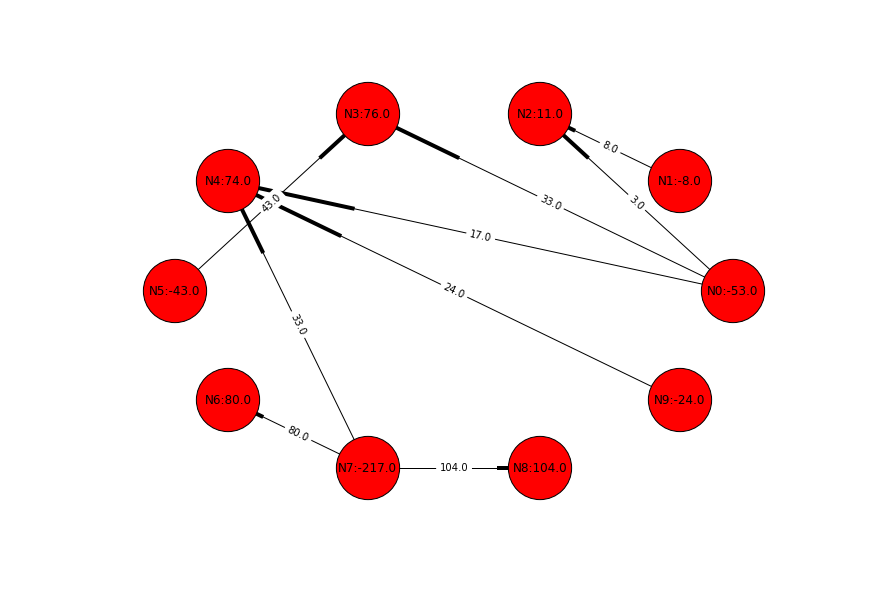

In [4]:
import cvxpy as cvx

class UltraSolver():
    def solve(self, data):
        u = data.copy()
        people_number = data.shape[0]

        c = cvx.Variable(people_number, people_number)

        constraints = [cvx.sum_entries(c, axis = 1) - cvx.sum_entries(c, axis = 0).T == u.sum(axis = 1) - u.sum(axis = 0).T,
                       c >= 0]

        obj = cvx.Minimize(cvx.sum_entries(c))

        prob = cvx.Problem(obj, constraints)
        prob.solve(solver = 'GUROBI')
        
        return c.value

ultra_solver = UltraSolver()

people_number = 10
data = generate_adj_matrix(people_number, 0.2, True)
G = nx.DiGraph(data)
G_solution = nx.DiGraph(ultra_solver.solve(data))
draw_graph(G)
draw_graph(G_solution)

if check_solution(G, G_solution):
    print('Solution is valid')

Initial amount of arcs is 74
Reduced amount of arcs is 42
Solution is valid


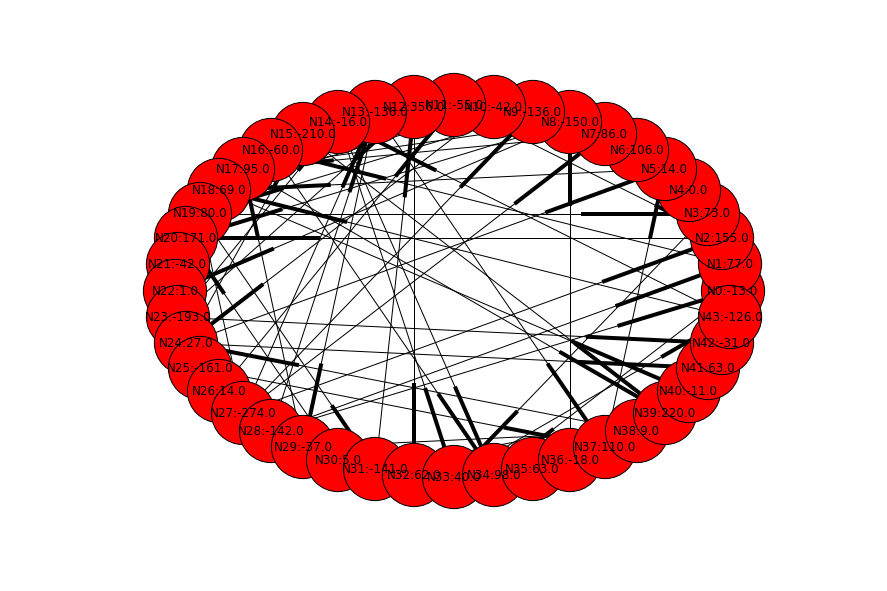

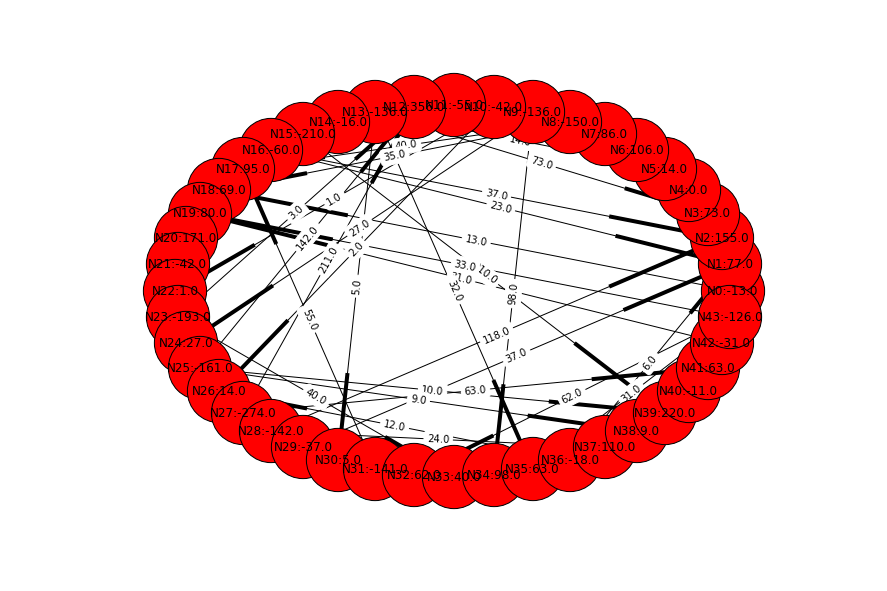

In [5]:
people_number = 44
data = generate_adj_matrix(people_number, 0.04, True)

G = nx.DiGraph(data)
G_solution = nx.DiGraph(ultra_solver.solve(data))

draw_graph(G, show_edges_labels = False)
draw_graph(G_solution)

print('Initial amount of arcs is {0}'.format(len(G.edges())))
print('Reduced amount of arcs is {0}'.format(len(G_solution.edges())))

if check_solution(G, G_solution):
    print('Solution is valid')

## Naive Random Optimization Search 

Let's try another formulation.
At first we want to kill all the cycles. The order matters and thus we want to solve the following problem:
* Kill cycles
* Not to create new relationships between nodes
* Reduce mutual debts

There is a property: given graph G, each node i of G has some input and some output verticies $V_{ji}$ and $V_{ij}$ respectively.

$b_i$ is the total balance of a node i is defined as follows: 
$$b_i =\sum_{j} V_{ji} - V_{ij}  $$

Here let's see what is the result of random cycle killing.

In [6]:
def remove_cycles_randomly(G_orig):
    G = G_orig.copy()
    
    while True:
        try:
            cycle = nx.find_cycle(G, orientation = 'ignore')

            min_edge_weight = np.inf
            edge_to_remove = None

            for v1, v2, direction in cycle:
                    weight = G.get_edge_data(v1, v2)['weight']

                    if weight < min_edge_weight:
                        min_edge_weight = weight
                        edge_to_remove = (v1, v2)

            for v1, v2, direction in cycle:
                old_edge_weight = G.get_edge_data(v1, v2)['weight']

                if direction == 'forward':
                    G.add_edge(v1, v2, weight = old_edge_weight - min_edge_weight)
                else:
                    G.add_edge(v1, v2, weight = old_edge_weight + min_edge_weight)

                if G.get_edge_data(v1, v2)['weight'] == 0:
                    G.remove_edge(v1, v2)

        except nx.NetworkXNoCycle:
            break
            
    return G

Solution is valid


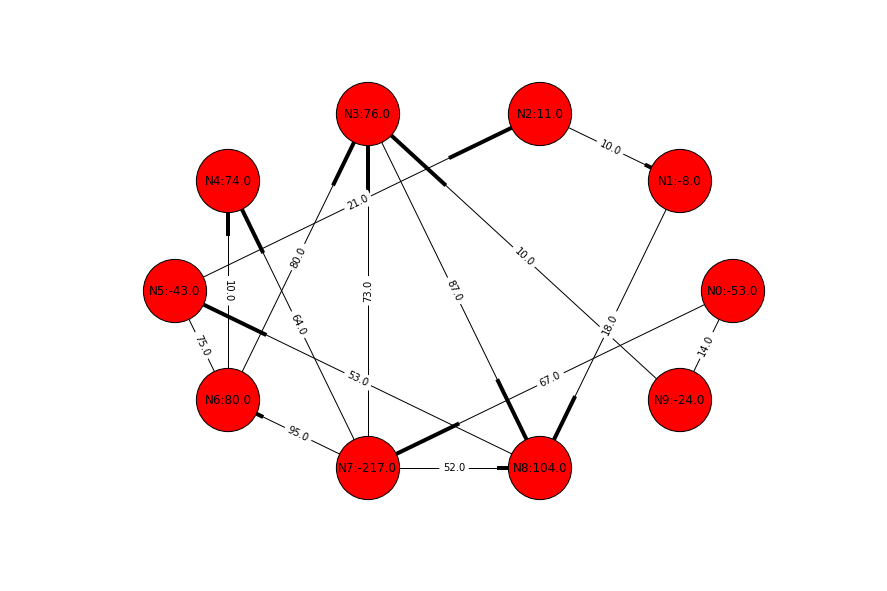

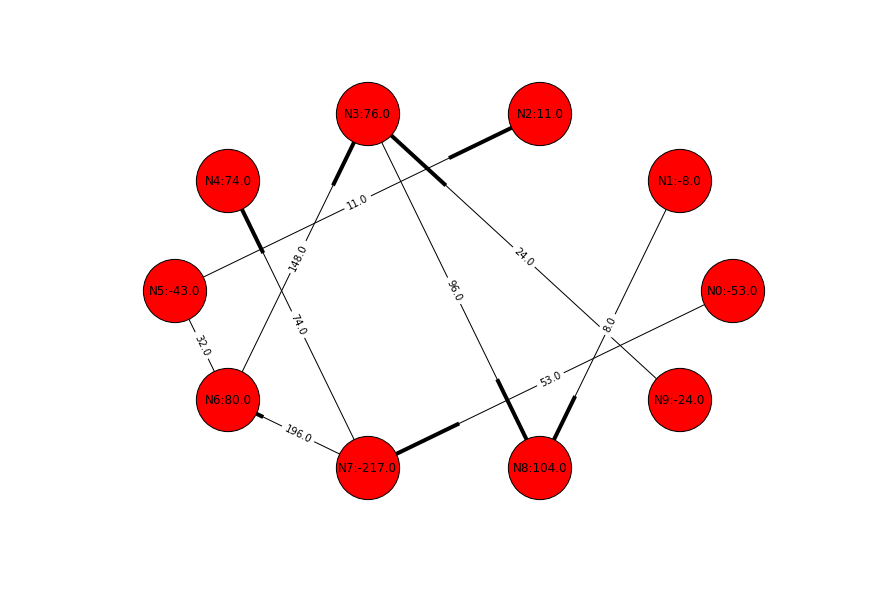

In [7]:
people_number = 10
data = generate_adj_matrix(people_number, 0.2, True)

G = nx.DiGraph(data)
G_solution = remove_cycles_randomly(G)

draw_graph(G)
draw_graph(G_solution)

if check_solution(G, G_solution):
    print('Solution is valid')

We can see, that removing of cycles doesn't affect chains. But the most important property is that all the existing edges are not new, but were already existed. Now this graph is acyclic and thus it is a tree. Let's try to do smth with chains.

Solution is valid


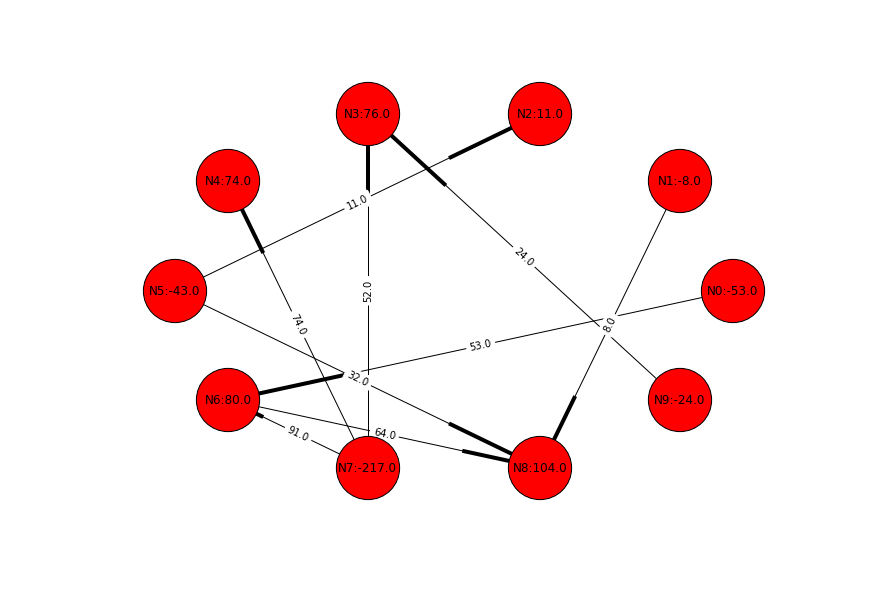

In [8]:
def kill_chains_randomly(G_orig):
    G = G_orig.copy()
    
    for node in G.nodes():
        out_edges = G.out_edges([node])
        in_edges = G.in_edges([node])

        while len(out_edges) > 0 and len(in_edges) > 0:
            in_edge = in_edges.pop()
            out_edge = out_edges.pop()

            in_weight = G.get_edge_data(in_edge[0], in_edge[1])['weight']
            out_weight = G.get_edge_data(out_edge[0], out_edge[1])['weight']

            if in_weight == out_weight:
                G.remove_edge(in_edge[0], node)
                G.remove_edge(node, out_edge[1])
                G.add_edge(in_edge[0], out_edge[1], weight = in_weight)
            elif in_weight > out_weight:
                G.remove_edge(node, out_edge[1])
                G.add_edge(in_edge[0], out_edge[1], weight = out_weight)
                G.add_edge(in_edge[0], node, weight = in_weight - out_weight)
            elif in_weight < out_weight:
                G.remove_edge(in_edge[0], node)
                G.add_edge(in_edge[0], out_edge[1], weight = in_weight)
                G.add_edge(node, out_edge[1], weight = out_weight - in_weight)
        
    return G

random_chain_killed_graph = kill_chains_randomly(G_solution)
draw_graph(random_chain_killed_graph)

if check_solution(G, random_chain_killed_graph):
    print('Solution is valid')

Now let's combine this random strategy in one solver and then we will compare with it.

In [9]:
class RandomSolver():
    def remove_cycles_randomly(self, G_orig):
        G = G_orig.copy()

        while True:
            try:
                cycle = nx.find_cycle(G, orientation = 'ignore')

                min_edge_weight = np.inf
                edge_to_remove = None

                for v1, v2, direction in cycle:
                        weight = G.get_edge_data(v1, v2)['weight']

                        if weight < min_edge_weight:
                            min_edge_weight = weight
                            edge_to_remove = (v1, v2)

                for v1, v2, direction in cycle:
                    old_edge_weight = G.get_edge_data(v1, v2)['weight']

                    if direction == 'forward':
                        G.add_edge(v1, v2, weight = old_edge_weight - min_edge_weight)
                    else:
                        G.add_edge(v1, v2, weight = old_edge_weight + min_edge_weight)

                    if G.get_edge_data(v1, v2)['weight'] == 0:
                        G.remove_edge(v1, v2)

            except nx.NetworkXNoCycle:
                break

        return G
    
    def kill_chains_randomly(self, G_orig):
        G = G_orig.copy()

        while True:
            exchanges_count = 0

            for node in G.nodes():
                out_edges = G.out_edges([node])
                in_edges = G.in_edges([node])

                while len(out_edges) > 0 and len(in_edges) > 0:
                    in_edge = in_edges.pop()
                    out_edge = out_edges.pop()

                    in_weight = G.get_edge_data(in_edge[0], in_edge[1])['weight']
                    out_weight = G.get_edge_data(out_edge[0], out_edge[1])['weight']

                    if in_weight == out_weight:
                        G.remove_edge(in_edge[0], node)
                        G.remove_edge(node, out_edge[1])
                        G.add_edge(in_edge[0], out_edge[1], weight = in_weight)
                    elif in_weight > out_weight:
                        G.remove_edge(node, out_edge[1])
                        G.add_edge(in_edge[0], out_edge[1], weight = out_weight)
                        G.add_edge(in_edge[0], node, weight = in_weight - out_weight)
                    elif in_weight < out_weight:
                        G.remove_edge(in_edge[0], node)
                        G.add_edge(in_edge[0], out_edge[1], weight = in_weight)
                        G.add_edge(node, out_edge[1], weight = out_weight - in_weight)
                        
                    exchanges_count += 1
                    
            if exchanges_count == 0:
                break

        return G

    def solve(self, data):
        return self.kill_chains_randomly(self.remove_cycles_randomly(nx.DiGraph(data)))

In [10]:
people_number = 200
data = generate_adj_matrix(people_number, 0.2, True)
random_solver = RandomSolver()

G = nx.DiGraph(data)
G_solution = random_solver.solve(data)

print('Initial amount of arcs is {0}'.format(len(G.edges())))
print('Reduced amount of arcs is {0}'.format(len(G_solution.edges())))

if check_solution(G, G_solution):
    print('Solution is valid')

Initial amount of arcs is 7101
Reduced amount of arcs is 198
Solution is valid


Now let's compare solutions of ultra_solver and random_solver

Solution is valid


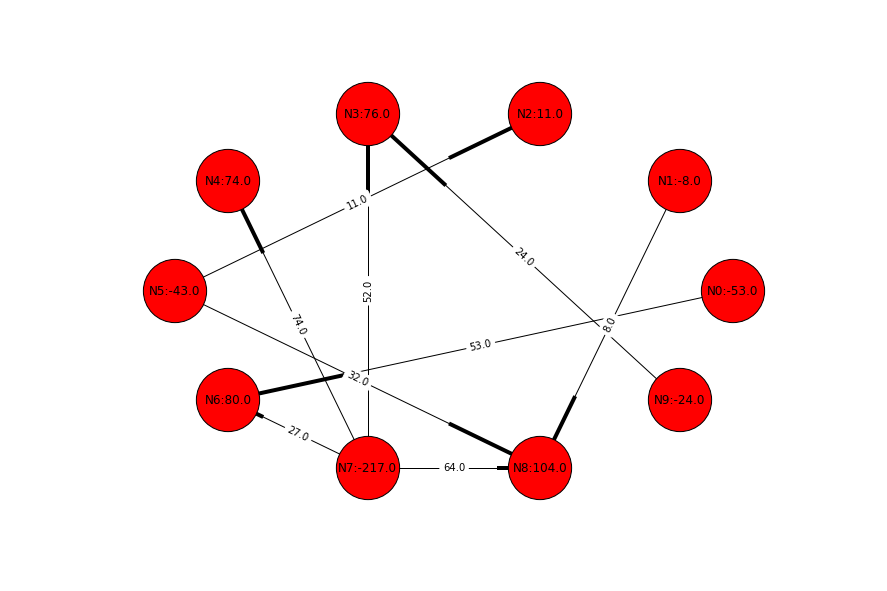

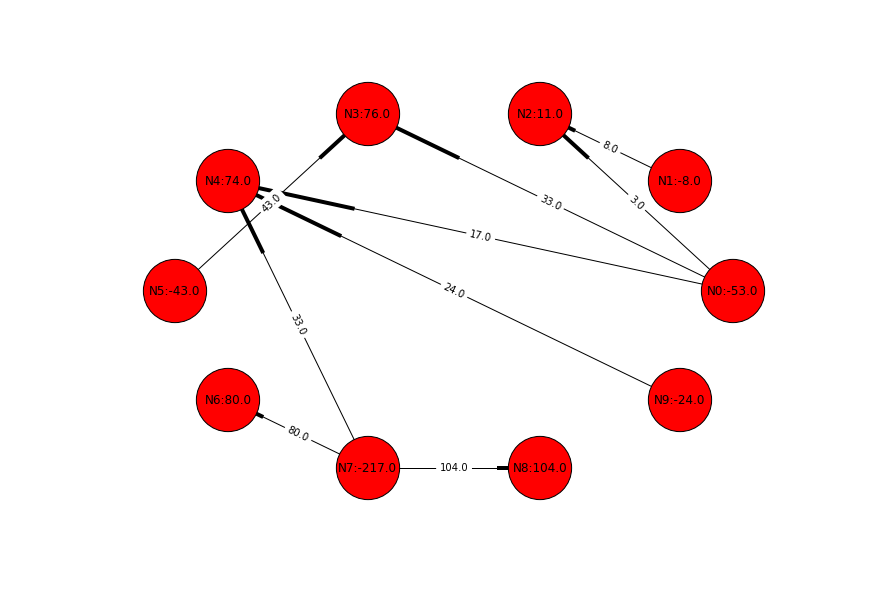

In [11]:
people_number = 10
data = generate_adj_matrix(people_number, 0.2, True)

G_random = random_solver.solve(data)
G_ultra = nx.DiGraph(ultra_solver.solve(data))

draw_graph(G_random)
draw_graph(G_ultra)

if check_solution(G_random, G_ultra):
    print('Solution is valid')

## Reputation between deptors

Now let's consider situation when reputation matters. Then we want to make a transaction through people with higher confidence. We can rewrite our problem in the folowing way:

$$\max_{x} \sum_{ij} confidence_i x_{ij}\\
\text{s.t.:}
0 \leq x_{ij} \leq 1\\
\sum_{i=1}^n c_{ij} - \sum_{j=1}^n c_{ij} = \sum_{i=1}^n u_{ij} - \sum_{j=1}^n u_{ij}\\
c_{ij} \leq x_{ij}
$$

In [12]:
import numpy as np

def generate_random_confidense(people_number):
    return np.random.randint(0, 100, people_number)

In [13]:
import cvxpy as cvx

class RepSolver():
    def solve(self, data, confidence):
        u = data.copy()
        people_number = data.shape[0]

        c = cvx.Variable(people_number, people_number)
        x = cvx.Variable(people_number, people_number)

        constraints = [cvx.sum_entries(c, axis=1) == cvx.pos(u.sum(axis=1) - u.sum(axis=0).T),
               cvx.sum_entries(c, axis=0) == cvx.pos(u.sum(axis=0) - u.sum(axis=1).T),
               c <= 1000 * x,
               c >= 0]

        obj = cvx.Minimize(cvx.sum_entries(confidence.T * x))

        problem = cvx.Problem(obj, constraints)
        problem.solve(solver = 'GUROBI')
        
        return c.value

Solution is valid


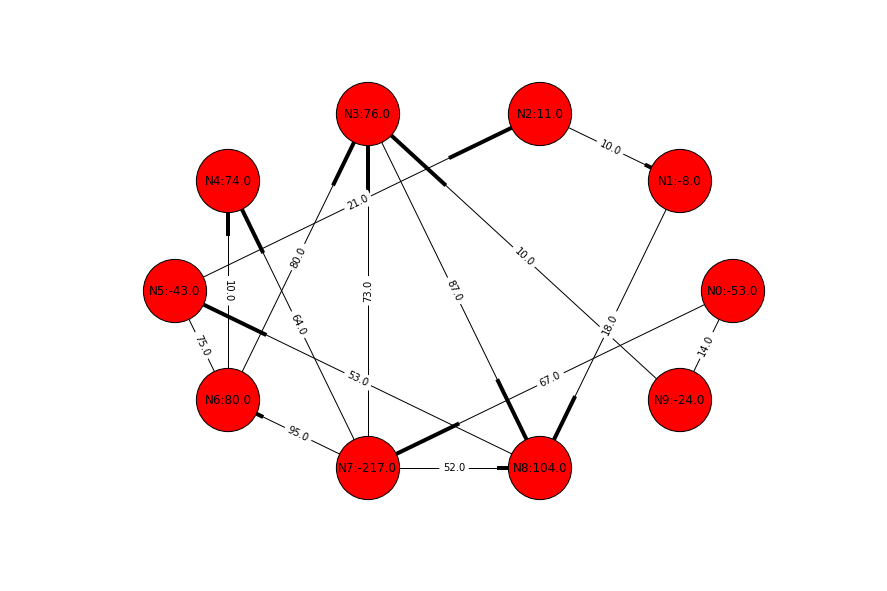

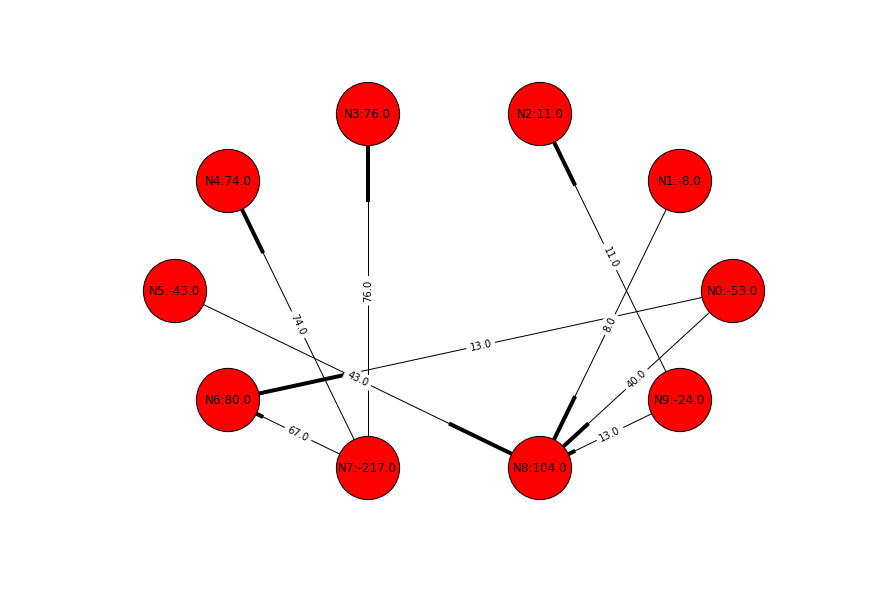

In [14]:
people_number = 10

rep_solver = RepSolver()
confidense = generate_random_confidense(people_number)
data = generate_adj_matrix(people_number, 0.2, True)

G = nx.DiGraph(data)
G_conf = nx.DiGraph(rep_solver.solve(data, confidense))

draw_graph(G)
draw_graph(G_conf)

if check_solution(G, G_conf):
    print('Solution is valid')